# Data Processing and Versioning

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sn
from azureml.core import Workspace, Dataset
from azureml.core.authentication import ServicePrincipalAuthentication
from azureml.core.authentication import InteractiveLoginAuthentication


In [3]:
# import dataset

df = pd.read_csv('Dataset/weather_dataset_raw.csv')

# 1. Data quality assessment 

In [4]:
df.head()

,S_No,Timestamp,Location,Temperature_C,Apparent_Temperature_C,Humidity,Wind_speed_kmph,Wind_bearing_degrees,Visibility_km,Pressure_millibars,Weather_conditions
0,0,2006-04-01 00:00:00+02:00,"Port of Turku, Finland",9.472222,7.388889,0.89,14.1197,251,15.8263,1015.13,rain
1,1,2006-04-01 01:00:00+02:00,"Port of Turku, Finland",9.355556,7.227778,0.86,14.2646,259,15.8263,1015.63,rain
2,2,2006-04-01 02:00:00+02:00,"Port of Turku, Finland",9.377778,9.377778,0.89,3.9284,204,14.9569,1015.94,rain
3,3,2006-04-01 03:00:00+02:00,"Port of Turku, Finland",8.288889,5.944444,0.83,14.1036,269,15.8263,1016.41,NaN
4,4,2006-04-01 04:00:00+02:00,"Port of Turku, Finland",8.755556,6.977778,0.83,11.0446,259,15.8263,1016.51,rain


In [5]:
df.describe()

,S_No,Temperature_C,Apparent_Temperature_C,Humidity,Wind_speed_kmph,Wind_bearing_degrees,Visibility_km,Pressure_millibars
count,96453.000000,96453.000000,96453.000000,96453.000000,96453.000000,96453.000000,96453.000000,96453.000000
mean,48226.000000,11.932678,10.855029,0.734899,10.810640,187.509232,10.347325,1003.235956
std,27843.727094,9.551546,10.696847,0.195473,6.913571,107.383428,4.192123,116.969906
min,0.000000,-21.822222,-27.716667,0.000000,0.000000,0.000000,0.000000,0.000000
25%,24113.000000,4.688889,2.311111,0.600000,5.828200,116.000000,8.339800,1011.900000
50%,48226.000000,12.000000,12.000000,0.780000,9.965900,180.000000,10.046400,1016.450000
75%,72339.000000,18.838889,18.838889,0.890000,14.135800,290.000000,14.812000,1021.090000
max,96452.000000,39.905556,39.344444,1.000000,63.852600,359.000000,16.100000,1046.380000


In [6]:
df.shape

(96453, 11)

In [7]:
df.dtypes

S_No                        int64
Timestamp                  object
Location                   object
Temperature_C             float64
Apparent_Temperature_C    float64
Humidity                  float64
Wind_speed_kmph           float64
Wind_bearing_degrees        int64
Visibility_km             float64
Pressure_millibars        float64
Weather_conditions         object
dtype: object

#### Check for missing data

In [8]:
df.isnull().values.any()

True

# 2. Calibrate missing data

In [9]:
df['Weather_conditions'].fillna(method='ffill',inplace=True,axis=0)

In [10]:
df.isnull().values.any()

False

In [11]:
df.Weather_conditions.value_counts()

rain     82271
snow     10712
clear     3470
Name: Weather_conditions, dtype: int64

In [12]:
df["Weather_conditions"].replace({"snow": "no_rain", "clear": "no_rain"}, inplace=True)

In [13]:
df.Weather_conditions.value_counts()

rain       82271
no_rain    14182
Name: Weather_conditions, dtype: int64

#### Convert Timestamp to Datetime format

In [14]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

#### Convert text data to numeric using Label Encoding

In [15]:
y = df['Weather_conditions']

In [16]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
y=le.fit_transform(y)

In [17]:
y = pd.DataFrame(data=y, columns=["Current_weather_condition"])

In [18]:
df = pd.concat([df, y], axis=1)

In [19]:
df.Current_weather_condition.value_counts()

1    82271
0    14182
Name: Current_weather_condition, dtype: int64

In [20]:
df.drop(['Weather_conditions'],axis=1,inplace=True)

#### Future Weather_condition

In [21]:
df['Future_weather_condition'] = df.Current_weather_condition.shift(4, axis = 0) 

In [22]:
df.dropna(inplace=True)

In [23]:
df['Future_weather_condition'] = df['Future_weather_condition'].apply(np.int64)

In [24]:
# Result - rain is 0 and no_rain is 1
df.head()

,S_No,Timestamp,Location,Temperature_C,Apparent_Temperature_C,Humidity,Wind_speed_kmph,Wind_bearing_degrees,Visibility_km,Pressure_millibars,Current_weather_condition,Future_weather_condition
4,4,2006-04-01 04:00:00+02:00,"Port of Turku, Finland",8.755556,6.977778,0.83,11.0446,259,15.8263,1016.51,1,1
5,5,2006-04-01 05:00:00+02:00,"Port of Turku, Finland",9.222222,7.111111,0.85,13.9587,258,14.9569,1016.66,1,1
6,6,2006-04-01 06:00:00+02:00,"Port of Turku, Finland",7.733333,5.522222,0.95,12.3648,259,9.9820,1016.72,1,1
7,7,2006-04-01 07:00:00+02:00,"Port of Turku, Finland",8.772222,6.527778,0.89,14.1519,260,9.9820,1016.84,1,1
8,8,2006-04-01 08:00:00+02:00,"Port of Turku, Finland",10.822222,10.822222,0.82,11.3183,259,9.9820,1017.37,1,1


## b) Understanding Correlations between data (columns)

In [25]:
df.corr(method ='pearson')

,S_No,Temperature_C,Apparent_Temperature_C,Humidity,Wind_speed_kmph,Wind_bearing_degrees,Visibility_km,Pressure_millibars,Current_weather_condition,Future_weather_condition
S_No,1.000000,0.025460,0.026591,0.041773,-0.006393,-0.027760,0.109075,0.016650,0.083009,0.082774
Temperature_C,0.025460,1.000000,0.992629,-0.632254,0.008959,0.029995,0.392876,-0.005446,0.378350,0.348167
Apparent_Temperature_C,0.026591,0.992629,1.000000,-0.602570,-0.056646,0.029039,0.381749,-0.000218,0.383877,0.357662
Humidity,0.041773,-0.632254,-0.602570,1.000000,-0.224957,0.000720,-0.369223,0.005451,-0.130966,-0.096626
Wind_speed_kmph,-0.006393,0.008959,-0.056646,-0.224957,1.000000,0.103815,0.100745,-0.049264,0.094135,0.066179
Wind_bearing_degrees,-0.027760,0.029995,0.029039,0.000720,0.103815,1.000000,0.047567,-0.011653,0.059540,0.061013
Visibility_km,0.109075,0.392876,0.381749,-0.369223,0.100745,0.047567,1.000000,0.059815,0.233356,0.227457
Pressure_millibars,0.016650,-0.005446,-0.000218,0.005451,-0.049264,-0.011653,0.059815,1.000000,0.040329,0.038392
Current_weather_condition,0.083009,0.378350,0.383877,-0.130966,0.094135,0.059540,0.233356,0.040329,1.000000,0.808768
Future_weather_condition,0.082774,0.348167,0.357662,-0.096626,0.066179,0.061013,0.227457,0.038392,0.808768,1.000000


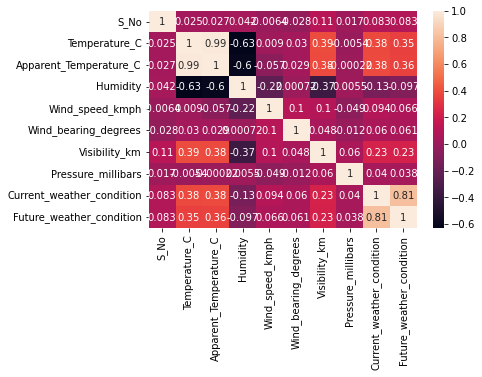

In [26]:
corrMatrix = df.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

In [27]:
# Filter or drop irrelevent data columns
df.drop(['S_No', 'Apparent_Temperature_C'],axis=1,inplace=True)

<AxesSubplot:>

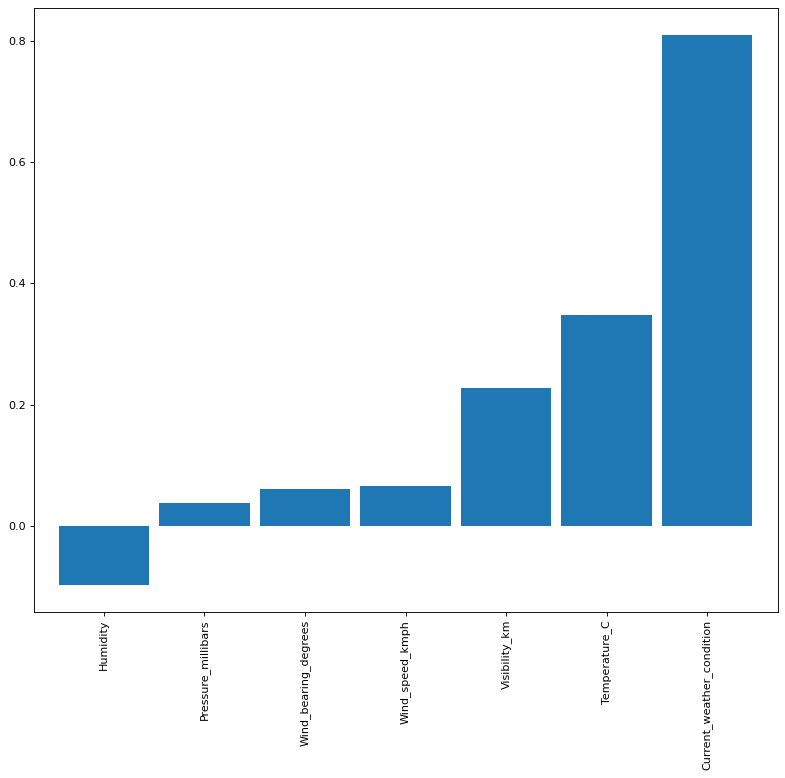

In [28]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='w')
df.corr(method ='pearson')['Future_weather_condition'].sort_values(ascending=True).drop(['Future_weather_condition']).plot(kind='bar', width=0.9)

## d) Timeseries analysis of Temperature

In [29]:
time = df['Timestamp']
temp = df['Temperature_C']

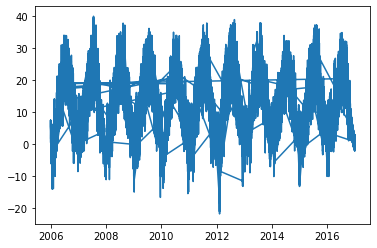

In [30]:
## plot graph
plt.plot(time, temp)
plt.show()

In [31]:
# Save processed dataset 
df.to_csv('Dataset/weather_dataset_processed.csv',index=False)

## Register dataset to the workspace

In [32]:
forced_interactive_auth = InteractiveLoginAuthentication(tenant_id='9b2ed62b-6e2e-49b7-9fa1-f5fc96afe074', force=True)
subscription_id = '4c763cc3-3b7e-46d1-93a2-62f85599e18c'
resource_group1 = 'WeatherChannelRG'
workspace_name1 = 'WeatherChannelWS'
resource_group2 = 'MlOPsAzure'
workspace_name2 = 'MlOPsAzureWS'

#workspace = Workspace(subscription_id, resource_group, workspace_name, ia)
ws = Workspace(subscription_id=subscription_id,
               resource_group=resource_group1,
               workspace_name=workspace_name1,
               auth=forced_interactive_auth)

Performing interactive authentication. Please follow the instructions on the terminal.


The default web browser has been opened at https://login.microsoftonline.com/9b2ed62b-6e2e-49b7-9fa1-f5fc96afe074/oauth2/v2.0/authorize. Please continue the login in the web browser. If no web browser is available or if the web browser fails to open, use device code flow with `az login --use-device-code`.


Interactive authentication successfully completed.


In [34]:
# get the datastore to upload prepared data
datastore = ws.get_default_datastore()

In [35]:
# upload the local file from src_dir to the target_path in datastore
datastore.upload(src_dir='Dataset', target_path='data')

"Datastore.upload" is deprecated after version 1.0.69. Please use "Dataset.File.upload_directory" to upload your files             from a local directory and create FileDataset in single method call. See Dataset API change notice at https://aka.ms/dataset-deprecation.


Uploading an estimated of 2 files
Uploading Dataset/weather_dataset_raw.csv
Uploaded Dataset/weather_dataset_raw.csv, 1 files out of an estimated total of 2
Uploading Dataset/weather_dataset_processed.csv
Uploaded Dataset/weather_dataset_processed.csv, 2 files out of an estimated total of 2
Uploaded 2 files


$AZUREML_DATAREFERENCE_c44c0bce9d44457988b67e46e1aa2b4f

In [36]:
dataset = Dataset.Tabular.from_delimited_files(datastore.path('data/weather_dataset_processed.csv'))

In [37]:
# preview the first 3 rows of the dataset from datastore
dataset.take(3).to_pandas_dataframe()

,Timestamp,Location,Temperature_C,Humidity,Wind_speed_kmph,Wind_bearing_degrees,Visibility_km,Pressure_millibars,Current_weather_condition,Future_weather_condition
0,2006-04-01 02:00:00,"Port of Turku, Finland",8.755556,0.83,11.0446,259,15.8263,1016.51,1,1
1,2006-04-01 03:00:00,"Port of Turku, Finland",9.222222,0.85,13.9587,258,14.9569,1016.66,1,1
2,2006-04-01 04:00:00,"Port of Turku, Finland",7.733333,0.95,12.3648,259,9.9820,1016.72,1,1


In [38]:
# Register Dataset to workspace

In [39]:
weather_ds = dataset.register(workspace=ws,
                                 name='processed_weather_data_portofTurku',
                                 description='processed weather data')